In [20]:
from eeg_prep.network import state_lds_array
from eeg_prep.preprocess.ieeg import preprocess_ieeg
from eeg_prep.utils import compute_samplepoints
from connection_complexity.data.raw_data.EDF.edf_helpers import read_edf
from eeg_prep.metrics.sourcesink import state_sourcesink_array
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
WINSIZE_MSEC = 500
STEPSIZE_MSEC = 500
file = "f:\\data\\iEEG\\raw_ieeg\\baseline_patients\\baseline_edfs\\001_Baseline.EDF"
edf_path = "F:\\data\\iEEG\\raw_ieeg\\baseline_patients\\baseline_edfs"
output_path = "processed_files"
mapping_path = "f:\\manuscripts\\manuiscript_0001_hfo_rates\\data\\FULL_composite_patient_info.csv"
ilae_path = "c:\\Users\\wirel\\Downloads\\ravi_hfo_numbers~N59+v03.csv"
bad_channels_path = "F:\\manuscripts\\manuiscript_0001_hfo_rates\\data\\bad_ch_review.xlsx"



# get metadata
mappings = pd.read_csv(mapping_path)
ilae = pd.read_csv(ilae_path)
bad_channels = pd.read_excel(bad_channels_path)
bad_channels["use"] = bad_channels["use"].fillna(1)
bad_channels["use2"] = bad_channels["use2"].fillna(1)
bad_channels["use"] = bad_channels["use"].astype(bool)
bad_channels["use2"] = bad_channels["use2"].astype(bool)

# OR bad_channel columns
bad_channels["bad_channel"] = ~(bad_channels["use"] & bad_channels["use2"])

# for each patient in mappings, find the corresponding ilae number. The patient may not be in the ilae dataset but has a designation of seizureFree or not.
# if the patient is not in the ilae dataset, then use the seizureFree column to determine the ilae number where -1 is seizureFree and 100 is not seizureFree
ilae_numbers = {}
for pid in mappings["pid"].unique():
    if pid in ilae["patient"].values:
        ilae_numbers[pid] = ilae[ilae["patient"] == pid]["ilae"].values[0]
    else:
        if mappings[mappings["pid"] == pid]["seizureFree"].values[0] == True:
            ilae_numbers[pid] = -1
        else:
            ilae_numbers[pid] = 100

# now we have a dictionary of ilae numbers for each patient. Fill in the mappings dataframe with these numbers which has multiple rows for each patient
ilae_list = []
for pid in mappings["pid"]:
    ilae_list.append(ilae_numbers[pid])
mappings["ilae"] = ilae_list


# Perform the merge as before
mappings = mappings.merge(
    bad_channels[['pid', 'ch', 'bad_channel']],
    left_on=['pid', 'electrode'],
    right_on=['pid', 'ch'],
    how='left'
)

# Drop the 'ch' column if needed
mappings = mappings.drop(columns=['ch'])

# Fill NaN values in 'bad_channel' with 0
mappings['bad_channel'] = mappings['bad_channel'].fillna(0)


raw = read_edf(file, preload=True)
raw.info["line_freq"] = 60

raw = preprocess_ieeg(raw)

pid = int(file.split("\\")[-1].split("_")[0])

# remove bad channels
patient_info = mappings[mappings["pid"] == pid]

raw = raw.drop_channels(patient_info[patient_info["bad_channel"] == 1]["electrode"].values)

# average reference
sfreq = raw.info["sfreq"]

raw = raw.set_eeg_reference(ref_channels="average", projection=False, verbose=False)
winsize_samps = int(np.round(WINSIZE_MSEC * (sfreq / 1000)))
stepsize_samps = int(np.round(STEPSIZE_MSEC * (sfreq / 1000)))

# Compute the state-space model
data = raw.get_data()

A_mats = state_lds_array(
    data, winsize=winsize_samps, stepsize=stepsize_samps, l2penalty=0
)


Import saved version from h5

In [15]:
import h5py

with h5py.File("f:\\git\\eeg_prep\\me\\processed_files\\001_000500_000500.hdf5", "r") as f:
    A_mats_fromfile = f['data']["A_mats"][:]

In [16]:
print(A_mats.shape)
print(A_mats_fromfile.shape)

(118, 118, 609)
(118, 118, 609)


In [17]:
print(np.allclose(A_mats, A_mats_fromfile))

True


In [19]:
data.shape

(118, 312064)

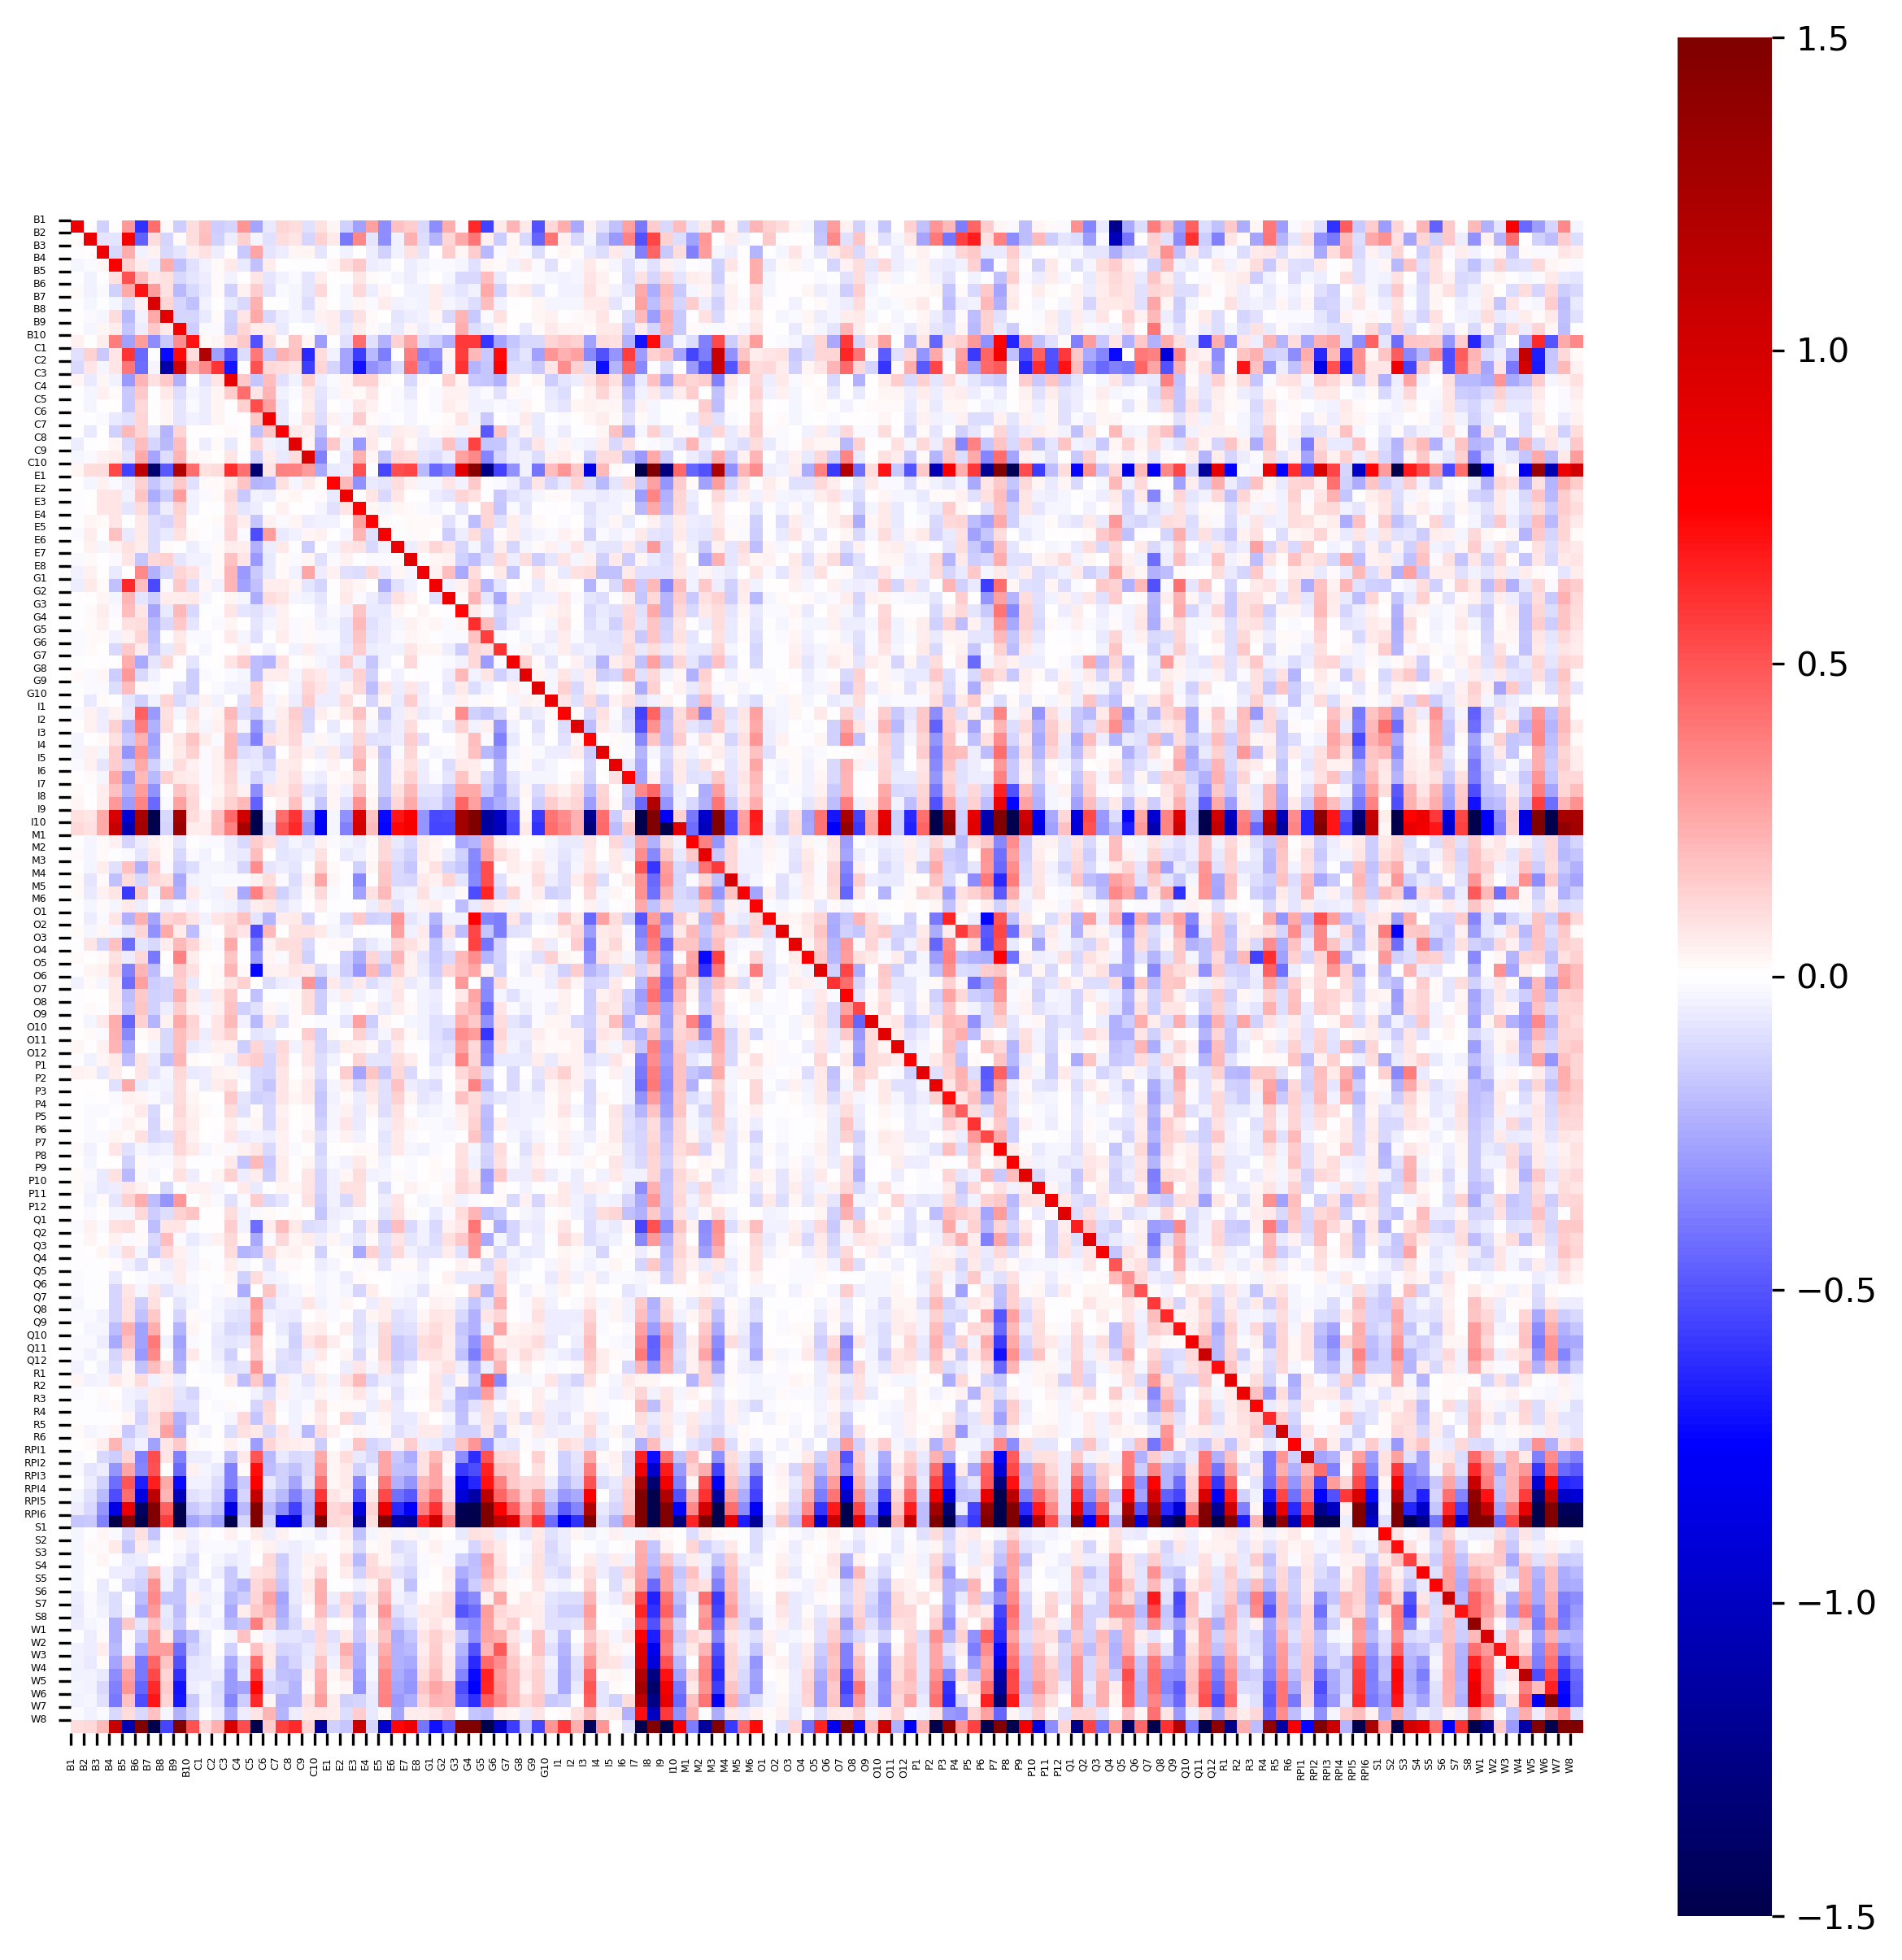

In [28]:
# plot unique A matrix heatmap
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(A_mats[:,:,1], cmap="seismic", center=0, square=True, vmax=1.5, vmin=-1.5)
# put channel names on the y-axis and x-axis
plt.yticks(np.arange(data.shape[0]), raw.ch_names, fontsize=3);
plt.xticks(np.arange(data.shape[0]), raw.ch_names, fontsize=3, rotation=90);

In [54]:
data.shape

(118, 312064)

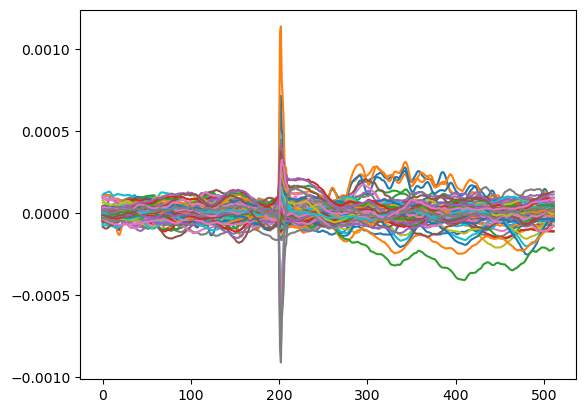

In [57]:
plt.plot(data[:,winsize_samps:2*winsize_samps].T);